# From RankNet to LambdaRank to LambdaMART: A Revisit

## 1. Sigmoid Function & Logistic Function

A sigmoid function **having a characteristic of S-shaped curve** is defined as follows,

$$ f(x)=\frac{1}{1+\exp(-\sigma x)} $$

A logistic function is defined as,

$$ f(x)=\frac{L}{1+\exp(-k(x-x_0))} $$

Commonly, with parameters ($k=1$, $x_0=0$, $L=1$), the standard logistic function is just a sigmoid function.

Text(0, 0.5, 'f(x)')

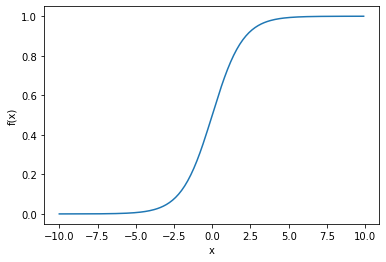

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-10, 10, 0.1)
f = 1. / (1. + np.exp(-x))

plt.plot(x, f)
plt.xlabel('x')
plt.ylabel('f(x)')

### 1.1 Gradient

The gradient of $f(x)$ w.r.t. $x$ is

$$ f'(x)=\sigma f(x)(1-f (x)) $$

## 2. RankNet

### 2.1 Essence

Cast the learning of a scoring function as a pairwise classification problem.

### 2.1 Formulation

Given two documents $d_i$ and $d_j$ that are represented as feature vectors $\mathbf{x}_i$ and $\mathbf{x}_j$, let $f$ be the ranking function, the ranking scores will be $s_i=f(\mathbf{x}_i)$ and $s_j=f(\mathbf{x}_j)$, the probability $p_{ij}$ indicating $d_i$ should be ranked higher than $d_j$ is given as

$$ p_{ij}=\frac{1}{1+\exp(-(s_i-s_j))} $$

Let $\bar{p_{ij}}$ be the known probability that $d_i$ should be ranked higher than $d_j$, we then apply the **cross entropy cost function** that penalizes the deviation of the model output probabilities from the desired probabilities,

$$ C=-\bar{p_{ij}} \log(p_{ij}) - (1-\bar{p_{ij}})\log(1-p_{ij}) $$

For a given query, let $S_{ij}\in \{-1, 0, 1\}$ be defined to be 1 if doc-i has been labeled to be more relevant than doc-j, −1 if doc-i has been labeled to be less relevant than doc-j, and 0 if they have the same label. In particular, we assume that the desired ranking is deterministically known, so that $\bar{p_{ij}}=\frac{1}{2}(1+S_{ij})$. Combining the above two equations gives

$$ C=\frac{1}{2}(1-S_{ij})(s_i-s_j) + \log(1+\exp(-(s_i-s_j))) $$

The cost is comfortingly **symmetric** (swapping $i$ and $j$ and changing the sign of $S_{ij}$ should leave the cost invariant): for $S_{ij}=1$,

$$ C=\log(1+\exp(-(s_i-s_j))) $$

while for $S_{ij}=-1$,

$$ C=\log(1+\exp(-(s_j-s_i))) $$

Note that when $s_i = s_j$, the cost is $\log2$, so the model incorporates a margin (that is, documents with different labels, but to which the model assigns the same scores, are still pushed away from each other in the ranking). Also, asymptotically, the cost becomes linear (if the scores give the wrong ranking), or zero (if they give the correct ranking).

For the gradient, essentially we have

$$\frac{\partial C}{\partial s_{i}}=\frac{1}{2}(1-S_{ij})-\frac{1}{1+e^{(s_{i}-s_{j})}}=-\frac{\partial C}{\partial s_{j}}$$

Furthermore,

\begin{equation}
\frac{\partial^{2} C}{\partial s_{i}^{2}}=\sigma (s_{j}-s_{i})(1-\sigma (s_{j}-s_{i}))
=\frac{1}{1+e^{(s_{i}-s_{j})}} (1-\frac{1}{1+e^{(s_{i}-s_{j})}})=-\frac{\partial^{2} C}{\partial s_{j}^{2}}
\end{equation}

### 2.3 Implementation
TBA

## 3. LambdaRank

### 3.1 Essence
Impose a weight on the pairwise loss in RankNet by simply multiplying the absolute change in terms of a specific evaluation metric when we swap the rank positions of the two documents within the currently predicted ranking while leaving the rank positions of other documents unchanged.

### 3.2 Formulation

The key observation of LambdaRank is that: in order to train a model, we don't need the costs themselves, and we only need the gradients of the costs w.r.t. the model scores.

We denote the gradient $\frac{\partial C}{\partial s_{i}}$ as $\lambda_{ij}$, namely

\begin{equation}
\lambda_{ij}=\frac{\partial C(s_{i}-s_{j})}{\partial s_{i}}=\frac{1}{2}(1-S_{ij})-\frac{1}{1+e^{(s_{i}-s_{j})}}
\end{equation}

LambdaRank mainly differs from RankNet in that: **modifying** the above gradient by simply multiplying by the size of change in a particular metric $|\Delta nDCG|$ (say, in term of $nDCG$) given by swapping the rank positions of $d_i$ and $d_j$ while leaving the rank positions of other documents unchanged.

### 3.3 Implementation